## 1. Compare true vis to calibrated vis, from the non-redundant-pipeline

It shows that there is a problem.

In [1]:
from pyuvdata import UVData
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 7]

Load the true model generated by generate_sims and the calibrated visibilities generated by analyse_sims.

generate_sims adds noise and gains and dumps a file with the \_g qualifier. analyse_sims loads the \_g file (make sure of this), calibrates it, and dumps a file with the \_g\_cal qualifier (make sure of this).  The "true" V is contained in a file with no qualifier. If all this is correct then the files below load the true V and the calibrated V.

In [2]:
vt = UVData()
vt.read_uvh5("/data/scratch/apw737/catall_nobright/viscatBC.uvh5")
vc = UVData()
vc.read_uvh5("/data/scratch/apw737/catall_nobright/viscatBC_g_cal.uvh5")

# Extract the first baseline over time/freq
true_data = vt.get_data(0, 1, "XX")
calibrated_data = vc.get_data(0, 1, "XX")


Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


\
Now compare the amplitude and phase of the calibrated vs true. Just flatten the values and plot 1-D.

**Amplitude**

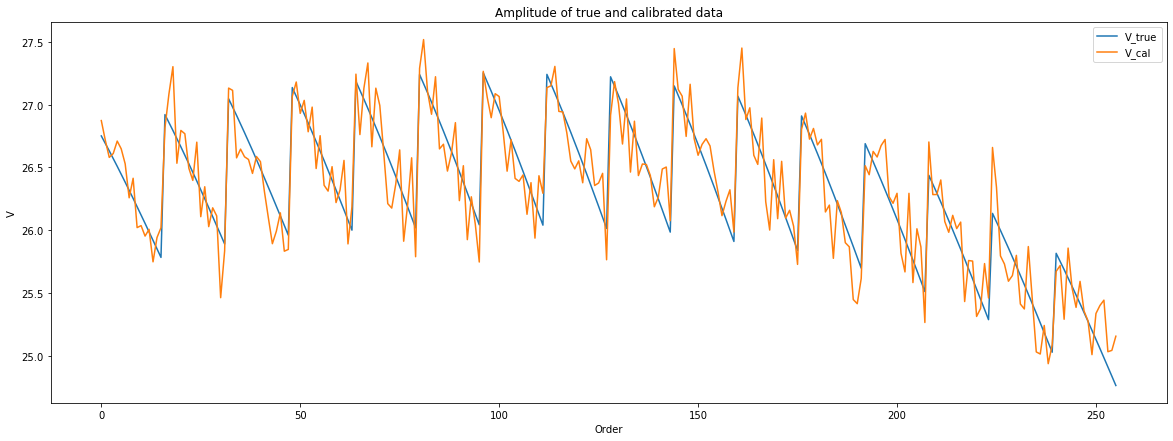

In [3]:
plt.plot(np.ravel(np.abs(true_data)), label="V_true")
plt.plot(np.ravel(np.abs(calibrated_data)), label="V_cal")     # get_calibrated_visibilities does d/gg 
plt.xlabel("Order")
plt.title("Amplitude of true and calibrated data")
plt.ylabel("V")
plt.legend()

Can see that the calibrated visibilities had noise added. But overall the amplitudes are the same.


**Phase**

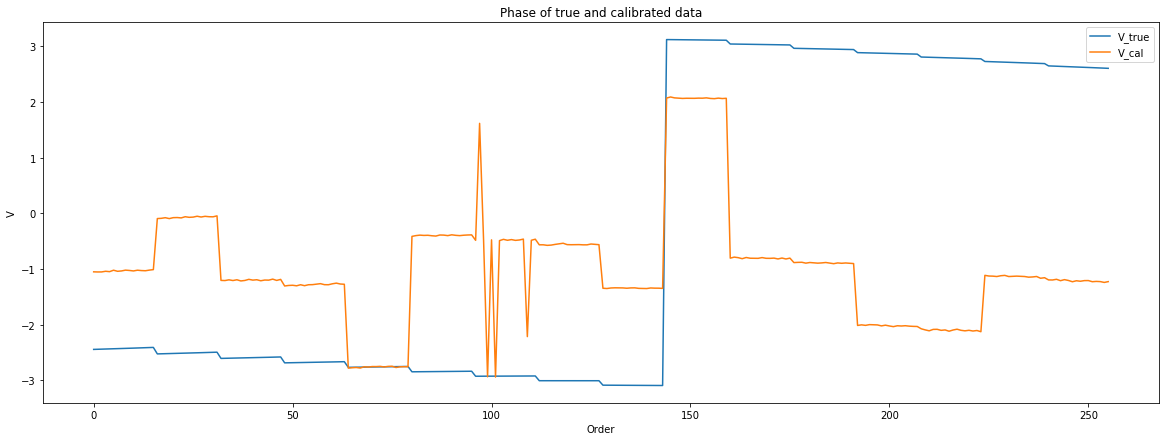

In [4]:
plt.plot(np.ravel(np.angle(true_data)), label="V_true")
plt.plot(np.ravel(np.angle(calibrated_data)), label="V_cal")     
plt.xlabel("Order")
plt.title("Phase of true and calibrated data")
plt.ylabel("V")
plt.legend()

The phases are clearly not the same

## 2. Fix recal degeneracies

The algorithm:

- calculate ggV = g g* V where g and V are the unmodified results from redcal
- rotate the phases of the redcal gains (g) to equal the phases of the true gains
- pass the rotated gains and the V to function remove_degen(), which gives new gains (ng) and new V (nV), 
    - remove_degen does do something but not enough. The Vs are the issue. They get changed slightly but the phases are wrong. So nV must be modified.
- calculate ngg = ng ng*  i.e. this gives the combined gain term for the baselines
- rotate the phases of nV so that they are equal to the phases of ggV/ngg
- this means that the phase of ggV = g g* V is the same as the phase of nggV = ng ng* nV
- now there is a slight issue with redundancy. remove_degen preserves redundancy, but the phase shift does not exactly. There is slight variation in the V within a redundant group. I just use the mean as the V for the redundant group.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from vis_creator import  VisCal, VisTrue
import hera_cal as hc

In [14]:
def fix_redcal_degeneracies():
    """
    Use the true (input) gains to fix the degeneracy directions in a set of 
    redundantly-calibrated gain solutions. This replaces the absolute 
    calibration that would normally be applied to a real dataset in order to 
    fix the degeneracies.

    Note that this step should only be using the true gains to fix the 
    degeneracies, and shouldn't add any more information beyond that.

    N.B. This is just a convenience function for calling the 
    remove_degen_gains() method of the redcal.RedundantCalibrator class. It 
    also assumes that only the 'ee' polarization will be used.

    Parameters
    ----------
    red_gains : dict of array_like
        Dict containing 2D array of complex gain solutions for each antenna 
        (and polarization).
        This is cal['g_omnical']

    true_gains : dict
        Dictionary of true (input) gains as a function of frequency. 
        Expected format: 
            key = antenna number (int)
            value = 1D numpy array of shape (Nfreqs,)
        This is the g_new.calfits file.


    Returns
    -------
    new_gains : dict
        Dictionary with the same items as red_gains, but where the degeneracies 
        have been fixed in the gain solutions.

    uvc : UVCal, optional
        If outfile is specified, also returns a UVCal object containing the 
        updated gain solutions.
    """

    def un_key(gains):
        stripped = np.empty((gains[(0, "Jee")].shape[0], gains[(0, "Jee")].shape[1], len(gains.keys())), 
                            dtype=type(gains[(0, "Jee")][0, 0]))
        for i, key in enumerate(gains):
            ant = key[0]
            stripped[:, : ,ant] = gains[key]
        return stripped


    def rephase(a, b):
            # rephase a so it has the same phase as b
            return a*np.exp((np.angle(b)-np.angle(a))*1j)

    def rephase_dict(a, b):
        new_dict = {}
        for key in a:
            new_dict[key] = rephase(a[key], b[key])
            
        return new_dict

    print("Fixing degeneracies")
    


    # Need the redundant groups in the right format, antenna pairs and ee pol
    # Redundancy might have been removed but that's ok because each bl in a group still.
    reds = []
    for rg in vc.redundant_groups:
        new_rg = []
        for bl in rg:
            ants = vc.bl_to_ants[bl]
            ants = (ants[0], ants[1], "ee")
            new_rg.append(ants)
        reds.append(new_rg)

    # Create calibrator and dict for the work
    RedCal = hc.redcal.RedundantCalibrator(reds)
    
    # Save the ggV out of redcal
    ggV = vc.get_simulated_visibilities()

    g_bar = rephase(vc.g_bar.astype(np.complex128), vt.g_bar.astype(np.complex128))
        
    solution = {}
    for i in range(vc.nant):
        solution[(i, 'Jee')] = g_bar[:, :, i]
 
    V = vc.project_model()
    for i in range(vc.nvis):
        ant1 = vc.bl_to_ants[i][0]
        ant2 = vc.bl_to_ants[i][1]
        solution[(ant1, ant2, "ee")] = V[:, :, i]
        
    true_gains = {} 
    for i in range(vt.nant):
        true_gains[(i, 'Jee')] = vt.g_bar[:, :, i]

 
    new_sol = RedCal.remove_degen(solution, degen_sol=true_gains)
    
    # See if remove_degen preserved redundancy
    # Unpack V
    V = np.empty((vc.V_model.shape[0], vc.V_model.shape[1], vc.nvis), dtype=type(vc.V_model[0, 0, 0]))
    for i, key in enumerate(new_sol):
        if len(key) == 3:   # baseline
            bl = vc.bl_to_ants.index((key[0], key[1]))
            V[:, :, bl] = new_sol[key]               
 
    for bls in vc.redundant_groups:
        for bl in bls[1:]:
            assert np.allclose(V[:, :, bl], V[:, :, bls[0]]), "Redundancy not preserved by remove_degen"
 
    
    # Unpack g  
    for i, key in enumerate(new_sol):
        if len(key) == 2:   # ant
            ant = key[0]
            g_bar[:, : ,ant] = new_sol[key]           # Reusing g_bar
            
    # Now we want to rephase V so that ggV_phase = new_gg_phase+phase(rephased(V)).
    # Or: the new phase of V is the phase of ggV/new_gg. Need to construct new_gg.
    new_gg = np.zeros_like(ggV)
    for t in range(g_bar.shape[0]):
        for f in range(g_bar.shape[1]):
            k = 0
            for i in range(g_bar.shape[2]):
                for j in range(i+1, g_bar.shape[2]):
                    new_gg[t, f, k] = g_bar[t, f, i]*np.conj(g_bar[t, f, j])
                    k += 1


    V = rephase(V, ggV/new_gg)
    
            
    # See if redundancy has been preserved, model should be the same in each group. the amp is easy but the phase isn't due to wrapping.
    # In each group, subtract the visibility of a baseline from baseline0. Check that the result is small.
    for bls in vc.redundant_groups:
        for bl in bls[1:]:
            assert np.abs(np.max(V[:, :, bl]-V[:, :, bls[0]])) < 1

    
    # Ok, insert the model
    for t in range(g_bar.shape[0]):
        for f in range(g_bar.shape[1]):
            for i in range(vc.V_model.shape[2]):
                vc.V_model[t, f, i] = np.mean(V[t, f, vc.redundant_groups[i]])
        
    # Inset g_bar
    vc.g_bar = g_bar
        
limit_to = 200
plt.rcParams['figure.figsize'] = [20, 14]

In [17]:
vc = VisCal("/data/scratch/apw737/catall_nobright/viscatBC")
print("redcal rms", vc.get_unnormalized_likelihood(over_all=True, exp=False))
vt = VisTrue("/data/scratch/apw737/catall_nobright/viscatBC")
print("true sim rms", vt.get_unnormalized_likelihood(over_all=True, exp=False))
fix_redcal_degeneracies()
print(np.mean(vc.chi2["Jee"][0]), vc.get_chi2(over_all=True))

Get V_obs from /data/scratch/apw737/catall_nobright/viscatBC_g.uvh5
Get model from /data/scratch/apw737/catall_nobright/viscatBC_g_cal_dict.npz


Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


Get noise from /data/scratch/apw737/catall_nobright/viscatBC_nn.npz
redcal rms -91512.79803344248
Get true model from /data/scratch/apw737/catall_nobright/viscatBC.uvh5
Get true gains from /data/scratch/apw737/catall_nobright/viscatBC.calfits
Get V_obs from /data/scratch/apw737/catall_nobright/viscatBC_g.uvh5


Telescope hera_sim is not in known_telescopes.
telescope_location is not set. Using known values for HERA.
antenna_positions is not set. Using known values for HERA.
Telescope hera_sim is not in known_telescopes.


true sim rms -791.0577349196888
Fixing degeneracies
1.010276 1.1458644067381396


Text(0.5, 1.0, 'redcal phase(d), phase(s) limited to the first few values')

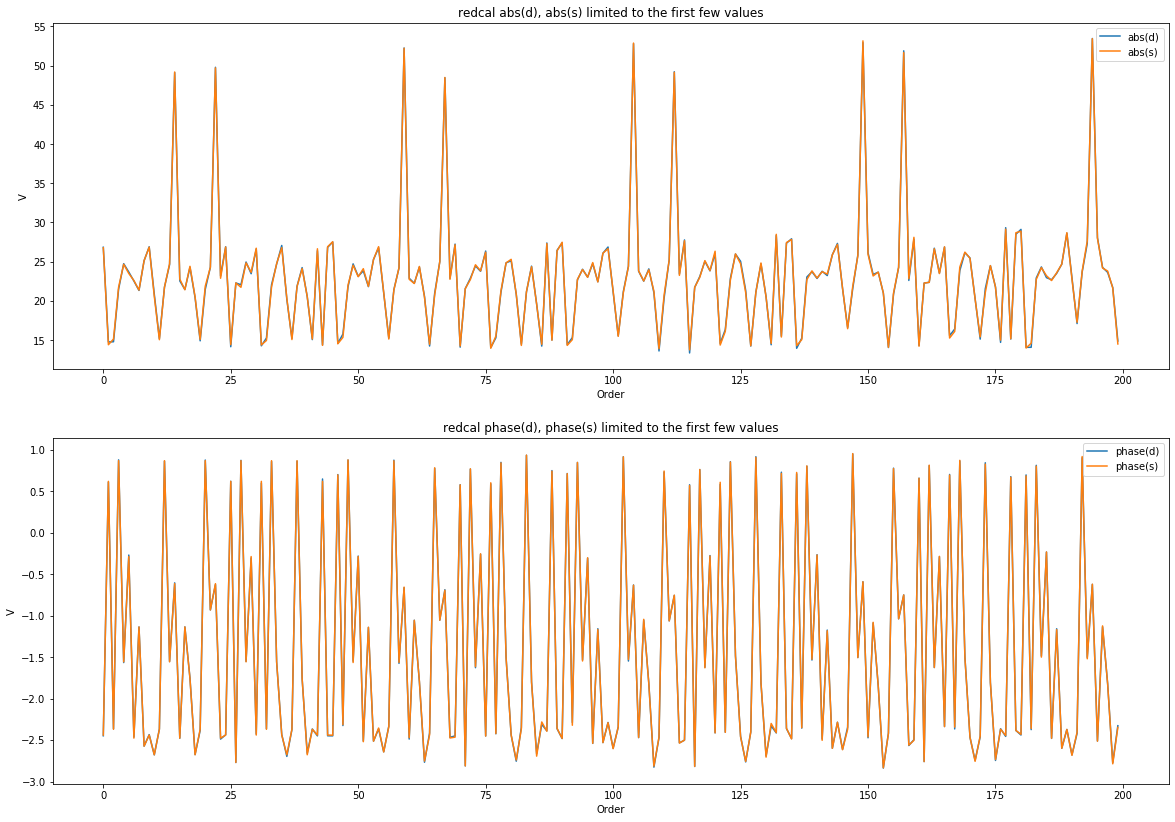

In [8]:
plt.subplot(2, 1, 1)
plt.plot(np.ravel(np.abs(vc.V_obs))[:limit_to], label="abs(d)")
plt.plot(np.abs(np.ravel(vc.get_simulated_visibilities()))[:limit_to], label="abs(s)")     # get_simulated visibilities does gg*V 
plt.xlabel("Order")
plt.ylabel("V")
plt.legend()
plt.title("redcal abs(d), abs(s) limited to the first few values")

plt.subplot(2, 1, 2)
plt.plot(np.ravel(np.angle(vc.V_obs))[:limit_to], label="phase(d)")
plt.plot(np.angle(np.ravel(vc.get_simulated_visibilities()))[:limit_to], label="phase(s)")     # get_simulated visibilities does gg*V 
plt.xlabel("Order")
plt.ylabel("V")
plt.legend()
plt.title("redcal phase(d), phase(s) limited to the first few values")

Text(0.5, 1.0, 'redcal phase(true V), phase(cal V) limited to the first few values')

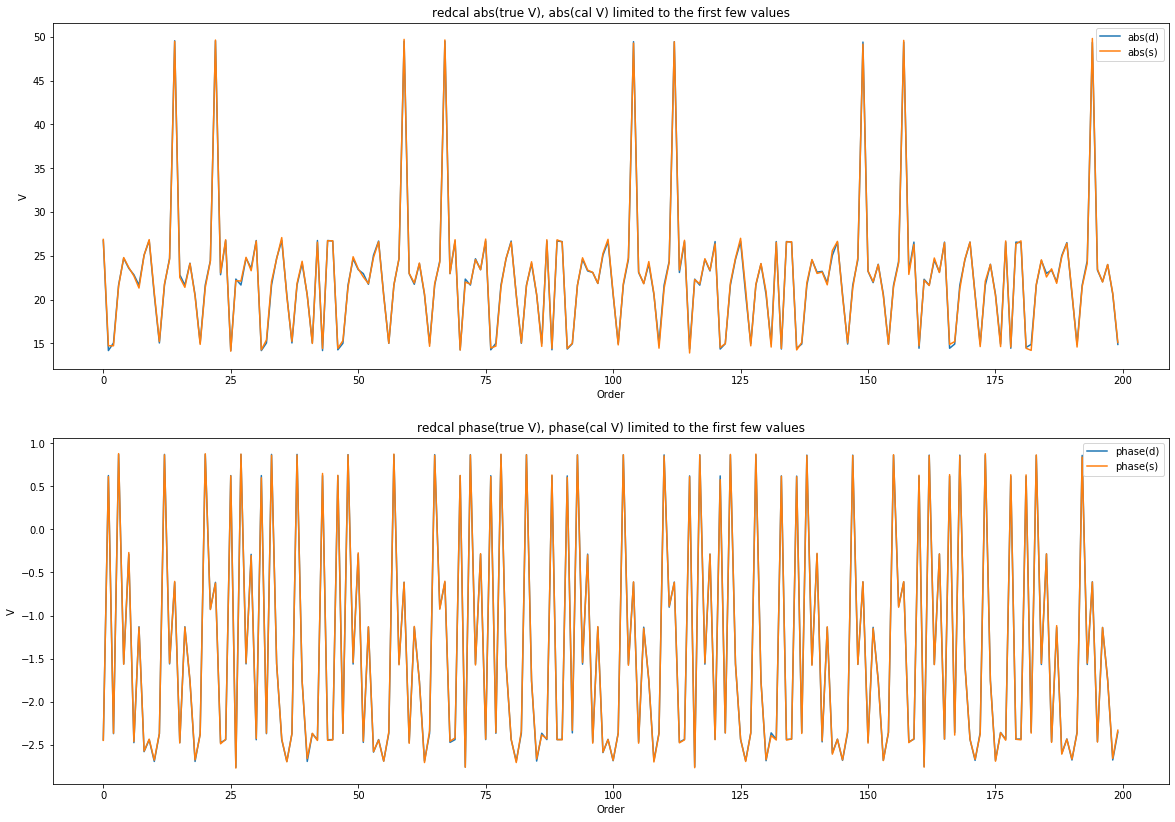

In [9]:
plt.subplot(2, 1, 1)
plt.plot(np.ravel(np.abs(vt.V_model))[:limit_to], label="abs(d)")
plt.plot(np.abs(np.ravel(vc.get_calibrated_visibilities()))[:limit_to], label="abs(s)")     # get_simulated visibilities does gg*V 
plt.xlabel("Order")
plt.ylabel("V")
plt.legend()
plt.title("redcal abs(true V), abs(cal V) limited to the first few values")

plt.subplot(2, 1, 2)
plt.plot(np.ravel(np.angle(vt.V_model))[:limit_to], label="phase(d)")
plt.plot(np.angle(np.ravel(vc.get_calibrated_visibilities()))[:limit_to], label="phase(s)")     # get_simulated visibilities does gg*V 
plt.xlabel("Order")
plt.ylabel("V")
plt.legend()
plt.title("redcal phase(true V), phase(cal V) limited to the first few values")

## Check that fix degeneracies works in sampler

In [10]:
from sampler import load_from_files
sampler = load_from_files("/data/scratch/apw737/catall_nobright/sampled_viscatBC")
sampler.fix_redcal_degeneracies()


Fixing degeneracies


Text(0.5, 1.0, 'redcal phase(d), phase(s) limited to the first few values')

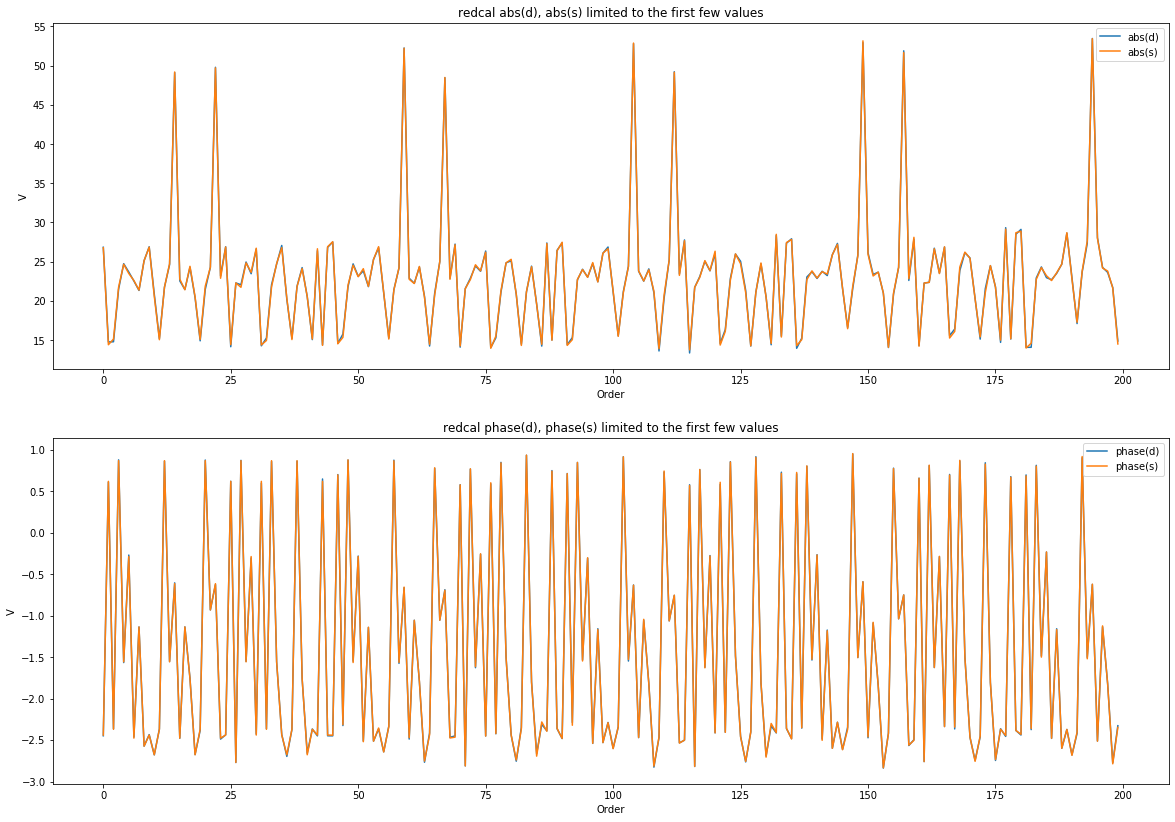

In [11]:
plt.subplot(2, 1, 1)
plt.plot(np.ravel(np.abs(sampler.vis_redcal.V_obs))[:limit_to], label="abs(d)")
plt.plot(np.abs(np.ravel(sampler.vis_redcal.get_simulated_visibilities()))[:limit_to], label="abs(s)")     # get_simulated visibilities does gg*V 
plt.xlabel("Order")
plt.ylabel("V")
plt.legend()
plt.title("redcal abs(d), abs(s) limited to the first few values")

plt.subplot(2, 1, 2)
plt.plot(np.ravel(np.angle(sampler.vis_redcal.V_obs))[:limit_to], label="phase(d)")
plt.plot(np.angle(np.ravel(sampler.vis_redcal.get_simulated_visibilities()))[:limit_to], label="phase(s)")     # get_simulated visibilities does gg*V 
plt.xlabel("Order")
plt.ylabel("V")
plt.legend()
plt.title("redcal phase(d), phase(s) limited to the first few values")

Text(0.5, 1.0, 'redcal phase(true V), phase(cal V) limited to the first few values')

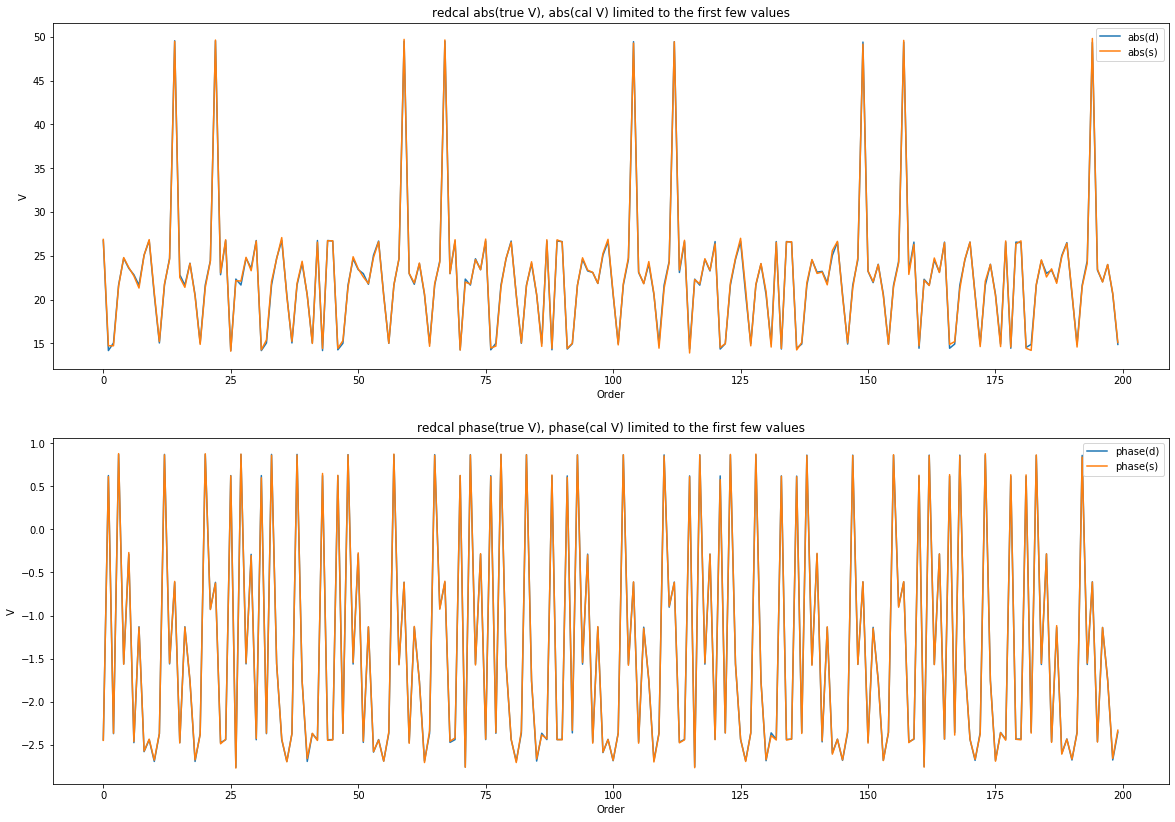

In [12]:
plt.subplot(2, 1, 1)
plt.plot(np.ravel(np.abs(sampler.vis_true.V_model))[:limit_to], label="abs(d)")
plt.plot(np.abs(np.ravel(sampler.vis_redcal.get_calibrated_visibilities()))[:limit_to], label="abs(s)")     # get_simulated visibilities does gg*V 
plt.xlabel("Order")
plt.ylabel("V")
plt.legend()
plt.title("redcal abs(true V), abs(cal V) limited to the first few values")

plt.subplot(2, 1, 2)
plt.plot(np.ravel(np.angle(sampler.vis_true.V_model))[:limit_to], label="phase(d)")
plt.plot(np.angle(np.ravel(sampler.vis_redcal.get_calibrated_visibilities()))[:limit_to], label="phase(s)")     # get_simulated visibilities does gg*V 
plt.xlabel("Order")
plt.ylabel("V")
plt.legend()
plt.title("redcal phase(true V), phase(cal V) limited to the first few values")